# CNN Keras
### **MOHAMED EL HADDIOUI  ,Data engineering student
#### 15/10/2023



* **1. Introduction**
* **2. Data preparation**
    * 2.1 Load data
    * 2.2 Check for null and missing values
    * 2.3 Normalization
    * 2.4 Reshape
    * 2.5 Label encoding
    * 2.6 Split training and valdiation set
* **3. CNN**
    * 3.1 Define the model
    * 3.2 Set the optimizer and annealer
    * 3.3 Data augmentation
* **4. Evaluate the model**
    * 4.1 Training and validation curves
    * 4.2 Confusion matrix
* **5. Prediction and submition**
    * 5.1 Predict and Submit results

# 1. Introduction

Ceci est un réseau neuronal convolutionnel séquentiel à 5 couches pour la reconnaissance des chiffres, entraîné sur l'ensemble de données MNIST. J'ai choisi de le construire avec l'API Keras (backend Tensorflow), qui est très intuitive. Tout d'abord, je vais préparer les données (images de chiffres manuscrits), puis je me concentrerai sur la modélisation et l'évaluation du réseau neuronal convolutionnel (CNN).

J'ai atteint une précision de 99,671 % avec ce CNN, entraîné en 2 heures et 30 minutes sur un seul CPU (i5 2500k). Pour ceux qui ont une carte graphique avec des capacités de calcul >= 3.0 (à partir de GTX 650 jusqu'aux cartes graphiques récentes), vous pouvez utiliser tensorflow-gpu avec Keras. Le calcul sera beaucoup plus rapide !!!

Pour des raisons de calcul, j'ai fixé le nombre d'étapes (epochs) à 2. Si vous souhaitez atteindre une précision de 99+% , réglez-le à 30.

Ce cahier (Notebook) suit trois parties principa
es :

La préparation des
 données
La modélisation et l'évaluati

n du CNN
La prédiction des résultats et la sle.png" ></img>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 2. Data preparation
## 2.1 Load data

In [9]:
# Load the data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/introduction-to-cnn-keras/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/introduction-to-cnn-keras/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

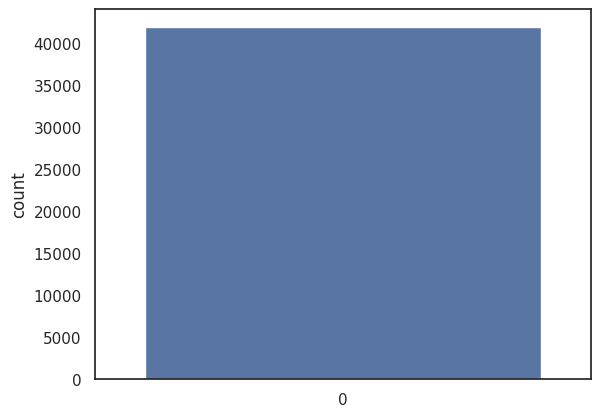

In [10]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

# free some space
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

We have similar counts for the 10 digits.

## 2.2 Check for null and missing values

In [11]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [12]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object



```
# Ce texte est au format code
```

Je vérifie les images corrompues (valeurs manquantes à l'intérieur).

Il n'y a aucune valeur manquante dans l'ensemble de données d'entraînement et de test. Nous pouvons donc continuer en toute sécurité.

## 2.3 Normalization

Nous effectuons une normalisation en niveaux de gris pour réduire l'effet des différences d'éclairage.

De plus, les CNN convergent plus rapidement sur des données comprises entre [0..1] que sur des données comprises entre [0..255].

In [13]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## 2.3 Reshape

In [14]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Les images d'entraînement et de test (28 px x 28 px) ont été stockées dans un pandas.DataFrame en tant que vecteurs 1D de 784 valeurs. Nous remodelons toutes les données en matrices 3D de taille 28x28x1.

Keras nécessite une dimension supplémentaire à la fin qui correspond aux canaux. Les images MNIST sont en niveaux de gris, donc elles n'utilisent qu'un seul canal. Pour les images RVB, il y a 3 canaux, nous aurions donc remodelé les vecteurs de 784 px en matrices 3D de taille 28x28x3.

## 2.5 Label encoding

In [16]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Les étiquettes sont des numéros à 10 chiffres de 0 à 9. Nous devons encoder ces étiquettes en vecteurs « one hot » (par exemple : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.6 Split training and valdiation set

In [18]:
# Set the random seed
random_seed = 2

In [19]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

J'ai choisi de diviser l'ensemble d'entraînement en deux parties : une petite fraction (10%) est devenue l'ensemble de validation sur lequel le modèle est évalué, et le reste (90%) est utilisé pour entraîner le modèle.

Étant donné que nous disposons de 42 000 images d'entraînement avec des étiquettes équilibrées (voir section 2.1 Chargement des données), une répartition aléatoire de l'ensemble d'entraînement ne provoque pas de sur-représentation de certaines étiquettes dans l'ensemble de validation. Soyez vigilant avec les ensembles de données déséquilibrés, car une simple répartition aléatoire peut entraîner une évaluation imprécise lors de la validation.

Pour éviter cela, vous pouvez utiliser l'option stratify = True dans la fonction train_test_split (uniquement pour les versions de sklearn >=0.17).

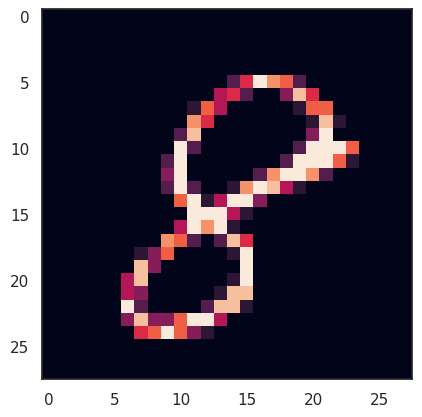

In [20]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

# 3. CNN
## 3.1 Define the model

J'ai utilisé l'API séquentielle de Keras, où vous devez ajouter une couche à la fois, en commençant par l'entrée.

La première est la couche de convolution (Conv2D). C'est comme un ensemble de filtres apprenables. J'ai choisi de définir 32 filtres pour les deux premières couches Conv2D et 64 filtres pour les deux dernières. Chaque filtre transforme une partie de l'image (définie par la taille du noyau) en utilisant le filtre de noyau. La matrice de filtre de noyau est appliquée sur toute l'image. Les filtres peuvent être considérés comme une transformation de l'image.

Le CNN peut isoler des caractéristiques utiles partout à partir de ces images transformées (cartes de caractéristiques).

La deuxième couche importante dans CNN est la couche de regroupement (MaxPool2D). Cette couche agit simplement comme un filtre de réduction d'échantillonnage. Elle examine les 2 pixels voisins et choisit la valeur maximale. Ils sont utilisés pour réduire le coût computationnel et, dans une certaine mesure, réduire également le surajustement. Nous devons choisir la taille du regroupement (c'est-à-dire la taille de la zone regroupée à chaque fois). Plus la dimension du regroupement est élevée, plus la réduction d'échantillonnage est importante.

En combinant les couches de convolution et de regroupement, les CNN peuvent combiner des caractéristiques locales et apprendre des caractéristiques plus globales de l'image.

Dropout est une méthode de régularisation, où une proportion de nœuds dans la couche est ignorée de manière aléatoire (en réglant leurs poids à zéro) pour chaque échantillon d'entraînement. Cela élimine de manière aléatoire une proportion du réseau et force le réseau à apprendre des caractéristiques de manière distribuée. Cette technique améliore également la généralisation et réduit le surajustement.

'relu' est le redresseur (fonction d'activation max(0,x)). La fonction d'activation redresseur est utilisée pour ajouter de la non-linéarité au réseau.

La couche Flatten est utilisée pour convertir les cartes de caractéristiques finales en un seul vecteur 1D. Cette étape d'aplatissement est nécessaire pour pouvoir utiliser des couches entièrement connectées après certaines couches de convolution/regroupement. Elle combine toutes les caractéristiques locales trouvées dans les couches de convolution précédentes.

À la fin, j'ai utilisé les caractéristiques dans deux couches entièrement connectées (Dense) qui sont simplement un classificateur de réseaux neuronaux artificiels (ANN). Dans la dernière couche (Dense(10, activation="softmax")), le réseau produit une distribution de probabilité de chaque classe.

In [21]:
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## 3.2 Configurer l'optimiseur et l'annealer

Une fois que nos couches sont ajoutées au modèle, nous devons mettre en place une fonction de score, une fonction de perte et un algorithme d'optimisation.

Nous définissons la fonction de perte pour mesurer à quel point notre modèle se comporte mal sur les images avec des étiquettes connues. Il s'agit du taux d'erreur entre les étiquettes observées et celles prédites. Nous utilisons une forme spécifique pour les classifications catégorielles (>2 classes) appelée "categorical_crossentropy".

La fonction la plus importante est l'optimiseur. Cette fonction améliorera de manière itérative les paramètres (valeurs des filtres, poids et biais des neurones, etc.) afin de minimiser la perte.

J'ai choisi RMSprop (avec des valeurs par défaut), c'est un optimiseur très efficace. La mise à jour RMSProp ajuste la méthode Adagrad d'une manière très simple dans le but de réduire son taux d'apprentissage agressif et monotone.

Nous aurions également pu utiliser l'optimiseur de descente de gradient stochastique ('sgd'), mais il est plus lent que RMSprop.

La fonction métrique "accuracy" est utilisée pour évaluer les performances de notre modèle. Cette fonction métrique est similaire à la fonction de perte, sauf que les résultats de l'évaluation métrique ne sont pas utilisés lors de l'entraînement du modèle (uniquement pour l'évaluation).

In [24]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)


In [25]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Pour que l'optimiseur converge plus rapidement et se rapproche le plus possible du minimum global de la fonction de perte, j'ai utilisé une méthode d'atténuation du taux d'apprentissage (LR).

Le LR est le pas par lequel l'optimiseur se déplace à travers le 'paysage de perte'. Plus le LR est élevé, plus les pas sont grands et plus la convergence est rapide. Cependant, l'échantillonnage est très faible avec un LR élevé et l'optimiseur pourrait probablement tomber dans un minimum local.

Il est préférable d'avoir un taux d'apprentissage décroissant pendant l'entraînement pour atteindre efficacement le minimum global de la fonction de perte.

Pour conserver l'avantage du temps de calcul rapide avec un LR élevé, j'ai diminué le LR dynamiquement toutes les X étapes (époques) en fonction de la nécessité (lorsque la précision n'est pas améliorée).

Avec la fonction ReduceLROnPlateau de Keras.callbacks, j'ai choisi de réduire le LR de moitié si la précision n'est pas améliorée après 3 époques.

In [26]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [27]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

## 3.3 Augmentation de données

Afin d'éviter le problème de surajustement, nous devons étendre artificiellement notre ensemble de données de chiffres manuscrits. Nous pouvons rendre votre ensemble de données existant encore plus grand. L'idée est de modifier les données d'entraînement avec de petites transformations pour reproduire les variations qui se produisent lorsque quelqu'un écrit un chiffre.

Par exemple, le chiffre n'est pas centré,
L'échelle n'est pas la même (certains écrivent avec des chiffres grands/petits),
L'image est inclinée...

Les approches qui modifient les données d'entraînement de manière à changer la représentation en tableau tout en conservant le libellé sont connues sous le nom de techniques d'augmentation de données. Certaines augmentations populaires que les gens utilisent sont les niveaux de gris, les retournements horizontaux, les retournements verticaux, les recadrages aléatoires, les variations de couleur, les translations, les rotations, et bien d'autres.

En appliquant seulement quelques-unes de ces transformations à nos données d'entraînement, nous pouvons facilement doubler ou tripler le nombre d'exemples d'entraînement et créer un modèle très robuste.

L'amélioration est importante :

Sans augmentation de données, j'ai obtenu une précision de 98,114%.
Avec l'augmentation de données, j'ai atteint une précision de 99,67%.

In [28]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
#          validation_data = (X_val, Y_val), verbose = 2)

In [29]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

Pour l'augmentation de données, j'ai choisi de :

Faire pivoter aléatoirement certaines images d'entraînement de 10 degrés
Effectuer un zoom aléatoire de 10% sur certaines images d'entraînement
Déplacer aléatoirement les images horizontalement de 10% de la largeur
Déplacer aléatoirement les images verticalement de 10% de la hauteur
Je n'ai pas appliqué de retournement vertical ni horizontal, car cela aurait pu entraîner une mauvaise classification de chiffres symétriques tels que 6 et 9.

Une fois que notre modèle est prêt, nous adaptons l'ensemble de données d'entraînement.

In [40]:
# Utilisez maintenant model.fit avec votre générateur de données
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=(X_val, Y_val),
                    verbose=2, steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction])


InvalidArgumentError: ignored

# 4. Evaluate the model
## 4.1 Training and validation curves

NameError: ignored

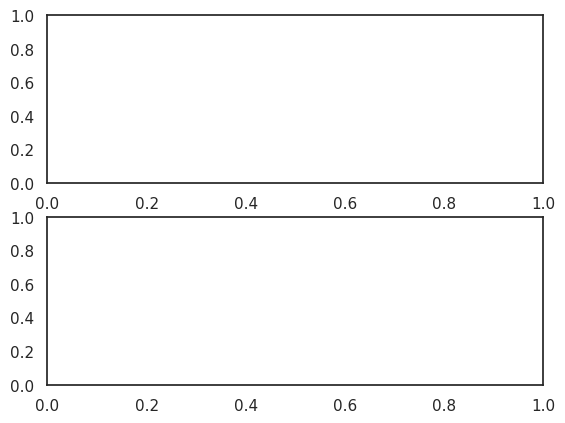

In [33]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The code below is for plotting loss and accuracy curves for training and validation. Since, i set epochs = 2 on this notebook .
I'll show you the training and validation curves i obtained from the model i build with 30 epochs (2h30)

<img src="http://img1.imagilive.com/0717/mnist_099671_train_val_loss_acc.png"></img>

The model reaches almost 99% (98.7+%) accuracy on the validation dataset after 2 epochs. The validation accuracy is greater than the training accuracy almost evry time during the training. That means that our model dosen't not overfit the training set.

Our model is very well trained  !!!

<img src="http://img1.imagilive.com/0717/accuracies1de.jpg"/>

## 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

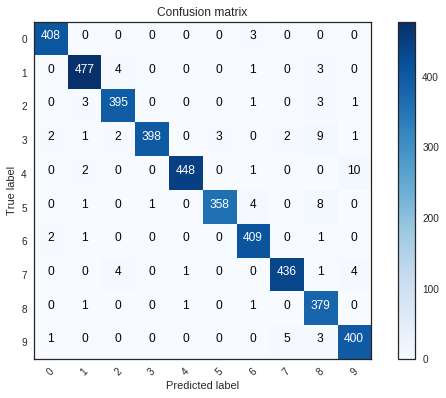

In [ ]:
# Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors.

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

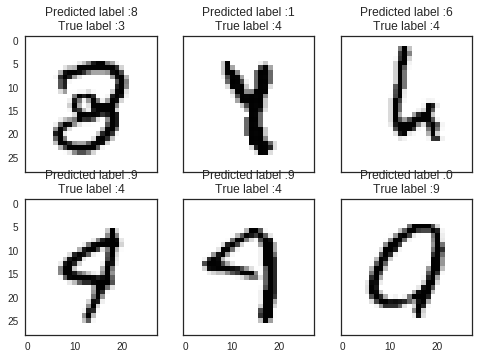

In [ ]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intrigous.

For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)



** you found this notebook helpful or you just liked it , some upvotes would be very much appreciated - That will keep me motivated :)**
